#Support Vestor Regression



$$
\text{SVR: } \min_{\mathbf{w}, b, \xi, \xi^*} \left\{ \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^{n} (\xi_i + \xi_i^*) \right\}
$$
$$
\text{subject to:}
$$
$$
\begin{cases}
y_i - (\mathbf{w} \cdot \mathbf{x}_i + b) \leq \epsilon + \xi_i \\
(\mathbf{w} \cdot \mathbf{x}_i + b) - y_i \leq \epsilon + \xi_i^* \\
\xi_i, \xi_i^* \geq 0, \quad i = 1, \ldots, n
\end{cases}
$$
$$
\text{where:}
$$
$$
\begin{align*}
\mathbf{w} & \text{ is the weight vector} \\
b & \text{ is the bias term} \\
\epsilon & \text{ is the margin of tolerance} \\
\xi_i, \xi_i^* & \text{ are the slack variables} \\
C & \text{ is the regularization parameter}
\end{align*}
$$

##Objective: Construct a Support Vector Regression to predict stock prices based on raw and enguneered features.

##Import Libraries

In [24]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import statsmodels.api as sm

import yfinance as yf

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

In [25]:
from IPython import display
display.set_matplotlib_formats('svg') # Improve matplotlib visual quality

<ipython-input-25-dcd5f3b50b37>:2: DeprecationWarning:

`set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`



##Import Dataset

In [26]:
# Financial Services Company: ['BAC', 'WFC', 'JPM']
# Investment Banking Companies: ['GS', 'MS', 'UBS']

ticker = ['BAC']
period = 'max'

stock_data = yf.download(ticker, period = period)[['Adj Close', 'Volume']]
stock_data

[*********************100%%**********************]  1 of 1 completed


,Adj Close,Volume
Date,,
1973-02-21,1.561252,99200
1973-02-22,1.566527,47200
1973-02-23,1.561252,133600
1973-02-26,1.561252,24000
1973-02-27,1.561252,41600
...,...,...
2024-06-28,39.770000,52028200
2024-07-01,40.009998,26770500
2024-07-02,40.930000,35626100


In [27]:
# plt.plot(stock_data.index, stock_data['Adj Close'])

##Data Preprocessing

###Feature Engineering

Features Engineered:


* **Log Returns:** log returns are being used because of its gaussian properties, they normalize stock returns.
* **Lagged values:** stock prices/returns often exhibit autocorrelation, past returns can influence future returns.
*   **Moving Averages:** they identify trends or cycles & crossovers of a short Simple Moving Average and long Simple Moving Averages often signal buy/sell periods.
* **Exponential Moving Average:** similar to a moving average but higher weight is placed on recent prices/returns which makes the indicator more responsive to information.
* **Volatility:** the degree of variation in stock prices, which is regarded as the riskiness of an asset.
* **Volume Moving Average:** high volume often indicates significant price movement and strong investor interest.
* **Treasury Rate:** the interest rates on debt securities issued by the U.S. Treasury. The relationship between Treasury rates and stock prices are generally considered inversely related.
* **Federal Funds Rate:** rate ar which depository institutions lend reserve balances to other depository institutions overnight. The rate influences other interest rates throughout the economy, such as, mortgages, credit card, and business loans.


In [28]:


# Lagged value
for lag in [1, 5, 10, 15]:
  stock_data[f'Lagged {lag}'] = stock_data['Adj Close'].shift(lag)

# Moving Averages
for window in [5, 14, 30]:
  stock_data[f'MA_{window}'] = stock_data['Adj Close'].rolling(window).mean()

# Exponential Moving Averages
for span in [12, 26]:
  stock_data[f'EMA_{span}'] = stock_data['Adj Close'].ewm(span = span, adjust=False).mean()

# Volatility Averages
for vol in [5, 14, 30]:
  stock_data[f'Volatility_{vol}'] = stock_data['Adj Close'].rolling(vol).std()

# Volume Averages
for window in [5, 14, 30]:
  stock_data[f'Volume_{window}_MA'] = stock_data['Volume'].rolling(window).mean()

# Fetch interest rate data from FRED
start_date = stock_data.index.min().strftime('%Y-%m-%d')
end_date = stock_data.index.max().strftime('%Y-%m-%d')

interest_rate = web.DataReader('DGS10', 'fred', start_date, end_date)
interest_rate.columns = ['10Y_Treasury_Rate']
stock_data = stock_data.join(interest_rate, how='left')
stock_data['10Y_Treasury_Rate'].fillna(method='ffill', inplace=True)

# Fetch Federal Funds Rate data from FRED
fed_rate = web.DataReader('FEDFUNDS', 'fred', start_date, end_date)
fed_rate.columns = ['Fed_Rate']
stock_data = stock_data.join(fed_rate, how='left')
stock_data['Fed_Rate'].fillna(method='ffill', inplace=True)

<ipython-input-28-940179f2b094>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-28-940179f2b094>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-28-940179f2b094>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
stock_data

,Adj Close,Volume,Lagged 1,Lagged 5,Lagged 10,Lagged 15,MA_5,MA_14,MA_30,EMA_12,EMA_26,Volatility_5,Volatility_14,Volatility_30,Volume_5_MA,Volume_14_MA,Volume_30_MA,10Y_Treasury_Rate,Fed_Rate
Date,,,,,,,,,,,,,,,,,,,
1973-02-21,1.561252,99200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.561252,1.561252,NaN,NaN,NaN,NaN,NaN,NaN,6.66,NaN
1973-02-22,1.566527,47200,1.561252,NaN,NaN,NaN,NaN,NaN,NaN,1.562063,1.561642,NaN,NaN,NaN,NaN,NaN,NaN,6.65,NaN
1973-02-23,1.561252,133600,1.566527,NaN,NaN,NaN,NaN,NaN,NaN,1.561938,1.561613,NaN,NaN,NaN,NaN,NaN,NaN,6.61,NaN
1973-02-26,1.561252,24000,1.561252,NaN,NaN,NaN,NaN,NaN,NaN,1.561833,1.561587,NaN,NaN,NaN,NaN,NaN,NaN,6.65,NaN
1973-02-27,1.561252,41600,1.561252,NaN,NaN,NaN,1.562307,NaN,NaN,1.561743,1.561562,0.002359,NaN,NaN,69120.0,NaN,NaN,6.64,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28,39.770000,52028200,39.250000,39.490002,39.259998,39.459999,39.484000,39.488572,39.351141,39.486031,39.236985,0.408938,0.363802,0.428552,37559220.0,3.853670e+07,3.621728e+07,4.36,5.33
2024-07-01,40.009998,26770500,39.770000,40.020000,39.240002,39.779999,39.482000,39.512857,39.385378,39.566642,39.294245,0.405672,0.387426,0.439019,36700340.0,3.779297e+07,3.602449e+07,4.48,5.33
2024-07-02,40.930000,35626100,40.009998,39.380001,39.509998,39.669998,39.792000,39.660715,39.447962,39.776389,39.415412,0.752343,0.498250,0.516851,37639840.0,3.714991e+07,3.636079e+07,4.43,5.33


In [30]:
# stock_data.drop(columns='Adj Close', inplace = True)
stock_data.dropna(inplace = True)

In [31]:
stock_data

,Adj Close,Volume,Lagged 1,Lagged 5,Lagged 10,Lagged 15,MA_5,MA_14,MA_30,EMA_12,EMA_26,Volatility_5,Volatility_14,Volatility_30,Volume_5_MA,Volume_14_MA,Volume_30_MA,10Y_Treasury_Rate,Fed_Rate
Date,,,,,,,,,,,,,,,,,,,
1973-04-03,1.571801,23200,1.582350,1.550703,1.603449,1.656193,1.582350,1.589509,1.598174,1.584883,1.590332,0.010549,0.035630,0.040644,84640.0,6.622857e+04,6.632000e+04,6.73,7.09
1973-04-04,1.561252,78400,1.571801,1.571801,1.582350,1.661467,1.580240,1.582727,1.598174,1.581248,1.588178,0.013755,0.030648,0.040644,72000.0,6.680000e+04,6.562667e+04,6.70,7.09
1973-04-05,1.555978,78400,1.561252,1.592899,1.555978,1.656193,1.572856,1.575946,1.597822,1.577360,1.585793,0.015104,0.024231,0.040972,63680.0,6.920000e+04,6.666667e+04,6.68,7.09
1973-04-06,1.555978,36000,1.555978,1.592899,1.555978,1.650918,1.565472,1.570294,1.597646,1.574070,1.583584,0.011435,0.017728,0.041145,53760.0,6.977143e+04,6.341333e+04,6.64,7.09
1973-04-09,1.555978,28000,1.555978,1.582350,1.550703,1.635095,1.560197,1.566904,1.597470,1.571287,1.581539,0.006877,0.015268,0.041317,48800.0,6.685714e+04,6.354667e+04,6.62,7.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28,39.770000,52028200,39.250000,39.490002,39.259998,39.459999,39.484000,39.488572,39.351141,39.486031,39.236985,0.408938,0.363802,0.428552,37559220.0,3.853670e+07,3.621728e+07,4.36,5.33
2024-07-01,40.009998,26770500,39.770000,40.020000,39.240002,39.779999,39.482000,39.512857,39.385378,39.566642,39.294245,0.405672,0.387426,0.439019,36700340.0,3.779297e+07,3.602449e+07,4.48,5.33
2024-07-02,40.930000,35626100,40.009998,39.380001,39.509998,39.669998,39.792000,39.660715,39.447962,39.776389,39.415412,0.752343,0.498250,0.516851,37639840.0,3.714991e+07,3.636079e+07,4.43,5.33


###Splitting the Dataset into Train & Test Sets

In [32]:
x = stock_data.drop(columns = 'Adj Close')
y = stock_data['Adj Close']

In [33]:
x.shape, y.shape

((12926, 18), (12926,))

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=1, shuffle=False)

In [35]:
x_train.shape, y_train.shape

((12279, 18), (12279,))

In [36]:
x_test

,Volume,Lagged 1,Lagged 5,Lagged 10,Lagged 15,MA_5,MA_14,MA_30,EMA_12,EMA_26,Volatility_5,Volatility_14,Volatility_30,Volume_5_MA,Volume_14_MA,Volume_30_MA,10Y_Treasury_Rate,Fed_Rate
Date,,,,,,,,,,,,,,,,,,
2021-12-07,40740800,41.298698,41.398777,43.083771,43.800587,41.392242,42.409167,43.341791,42.132084,42.556985,0.503738,1.110230,1.196288,56392440.0,5.140351e+07,4.425976e+07,1.48,0.08
2021-12-08,50560300,41.822533,40.812286,44.219505,43.828514,41.491396,42.267036,43.230468,42.005310,42.464472,0.398933,1.115064,1.225601,54384180.0,5.266041e+07,4.475594e+07,1.52,0.08
2021-12-09,37316700,41.308052,41.990913,44.340534,43.297886,41.416563,42.159589,43.157983,41.945531,42.401677,0.306099,1.098802,1.255234,50283240.0,5.313739e+07,4.447347e+07,1.49,0.08
2021-12-10,37700200,41.616749,41.036781,42.599678,43.121006,41.538167,42.115322,43.063471,41.899265,42.345613,0.228423,1.106704,1.258986,42902220.0,5.237101e+07,4.448982e+07,1.48,0.08
2021-12-13,38653900,41.644802,41.298698,42.441422,42.264553,41.431529,41.949732,42.939649,41.724841,42.228568,0.415783,1.123953,1.296946,40994380.0,5.129650e+07,4.471975e+07,1.42,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28,52028200,39.250000,39.490002,39.259998,39.459999,39.484000,39.488572,39.351141,39.486031,39.236985,0.408938,0.363802,0.428552,37559220.0,3.853670e+07,3.621728e+07,4.36,5.33
2024-07-01,26770500,39.770000,40.020000,39.240002,39.779999,39.482000,39.512857,39.385378,39.566642,39.294245,0.405672,0.387426,0.439019,36700340.0,3.779297e+07,3.602449e+07,4.48,5.33
2024-07-02,35626100,40.009998,39.380001,39.509998,39.669998,39.792000,39.660715,39.447962,39.776389,39.415412,0.752343,0.498250,0.516851,37639840.0,3.714991e+07,3.636079e+07,4.43,5.33


###Scaling the Dataset

In [37]:
scaled_x = StandardScaler()
scaled_y = StandardScaler()

The transformation applied to the test set must be consistent with the transformation applied to the training set. By using transform on the test set, you ensure that the same scaling parameters (mean and standard deviation) calculated from the training set are applied, maintaining consistency.

In [38]:
x_train_scaled = scaled_x.fit_transform(x_train)
x_test_scaled = scaled_x.transform(x_test)

y_train_scaled = scaled_y.fit_transform(y_train.values.reshape((-1, 1)))
y_test_scaled = scaled_y.transform(y_test.values.reshape((-1, 1)))

In [39]:
x_test_scaled

array([[ 0.028899  ,  2.79805627,  2.81181116, ...,  0.08091047,
        -1.4243805 , -1.19555839],
       [ 0.15226024,  2.84689454,  2.75706865, ...,  0.08774192,
        -1.41207067, -1.19555839],
       [-0.01411758,  2.79892833,  2.86708064, ...,  0.08385287,
        -1.42130304, -1.19555839],
       ...,
       [-0.03535639,  2.6779078 ,  2.62338042, ..., -0.02784249,
        -0.51653029,  0.08459128],
       [-0.26808884,  2.7636817 ,  2.58791146, ..., -0.03301425,
        -0.5380725 ,  0.08459128],
       [-0.18800925,  2.76088485,  2.61124624, ..., -0.0368345 ,
        -0.5380725 ,  0.08459128]])

##Train the Support Vector Regression Model

In [40]:
svr = SVR(kernel ='rbf')
svr.fit(x_train_scaled, y_train_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



SVR()

##Predict returns with model

In [41]:
pred = scaled_y.inverse_transform(svr.predict(x_test_scaled).reshape(-1, 1))

In [42]:
pred.shape, y_test_scaled.shape

((647, 1), (647, 1))

In [43]:
data = {
        'True Value': y_test.values.flatten(),
        'predicted': pred.flatten(),
        }

test_results = pd.DataFrame(data, index = y_test.index)
train_values = pd.DataFrame({'Trained Value': y_train})

combined = pd.concat([train_values, test_results])
combined

,Trained Value,True Value,predicted
Date,,,
1973-04-03,1.571801,NaN,NaN
1973-04-04,1.561252,NaN,NaN
1973-04-05,1.555978,NaN,NaN
1973-04-06,1.555978,NaN,NaN
1973-04-09,1.555978,NaN,NaN
...,...,...,...
2024-06-28,NaN,39.770000,38.721674
2024-07-01,NaN,40.009998,39.026452
2024-07-02,NaN,40.930000,38.949707


##Visualize results

In [44]:
px.line(combined, title = f'{ticker[0]} True vs. Predicted Price')

In [45]:
rmse = np.sqrt(mean_squared_error(y_test, pred))
print('Root Mean Squared Error is:', rmse)

Root Mean Squared Error is: 1.258535334289361


<Axes: title={'center': 'BAC Correlation'}>

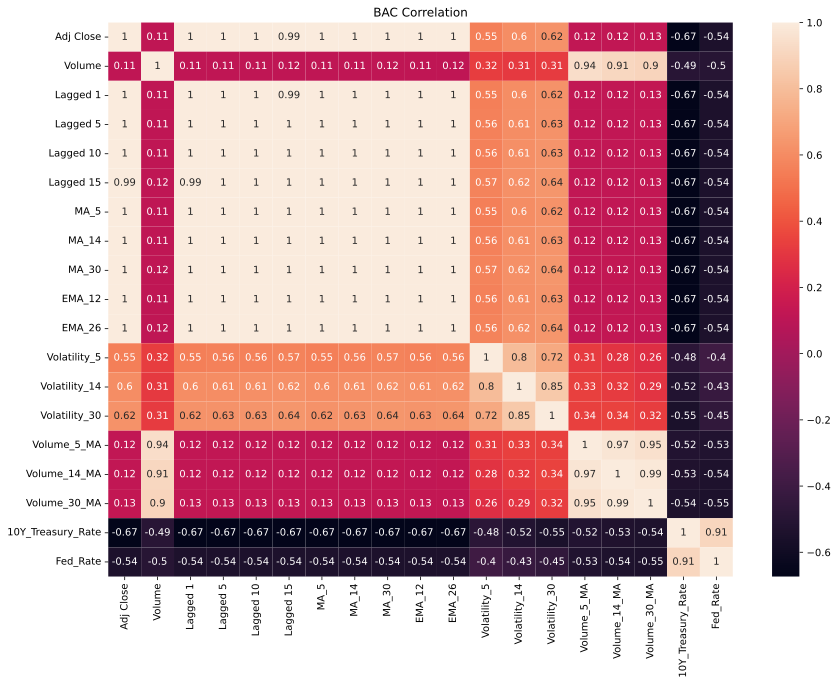

In [46]:
plt.figure(figsize=(14, 10))
plt.title(f'{ticker[0]} Correlation')
cor = stock_data.corr()
sns.heatmap(cor, annot = True)